In [1]:
import sys
import time
import torch
import torch.nn.functional as F
from utils.utils import load_data, mat2tensor, regression_loss
from model.gcn import GCN
from model.gat import GAT
import numpy as np
import dgl

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load data
features_list, adjM, labels, train_val_test_idx, dl = load_data('iYO844')

fea_list = list()
for features in features_list:
    if type(features) == np.ndarray:
        features = mat2tensor(features).to(device)
    elif type(features) == dict:
        features = {k: mat2tensor(v).to(device) for k, v in features.items()}
    fea_list.append(features)
    
features_list = fea_list

m_dim = features_list[1].shape[1]

# Set train, val, test index
labels = torch.FloatTensor(labels).to(device)
train_idx = train_val_test_idx['train_idx']
train_idx = np.sort(train_idx)
val_idx = train_val_test_idx['val_idx']
val_idx = np.sort(val_idx)
test_idx = train_val_test_idx['test_idx']
test_idx = np.sort(test_idx)

# Build graph
g = dgl.from_scipy(adjM+(adjM.T))
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)
g = g.to(device)

# Set model
num_labels = dl.labels_train['num_labels']

> Data loaded


In [10]:
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import networkx as nx

In [11]:
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)

In [28]:
train_idx

array([  0,  33,  47,  50,  64,  80,  88,  89,  91,  93, 108, 110, 155,
       159, 165, 167, 185, 195, 204, 207, 211, 212, 240, 252, 266, 267,
       283, 304, 318, 319, 332, 334, 373, 376])

In [56]:
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)

In [61]:
dataloader = dgl.dataloading.NodeDataLoader(
    g, val_idx, sampler,
    batch_size=len(val_idx),
    shuffle=True,
    drop_last=False,
    num_workers=4)

In [62]:
for input_nodes, output_nodes, blocks in dataloader:
    print(input_nodes)
    print(output_nodes)
    print(blocks)
    print('-------')

tensor([367, 375, 230, 131, 191, 203, 232, 302, 986, 987, 408, 553, 780, 883,
        994, 995, 387, 396, 546, 548, 549, 516, 601, 673, 742, 743, 584, 756,
        386, 403, 413, 787, 858, 366, 368,   8,  19,  85, 115, 153, 154, 160,
        222, 237, 256, 275, 313, 351, 383,  66, 221, 314,   1,  64,   3,  33,
         91,  92,  93, 103, 118, 155, 171, 206, 210, 211, 214, 218, 240, 248,
        253, 303, 304, 307, 342, 348, 346, 370, 243,  56, 107, 184, 185, 272,
        382,  88, 132, 249,  77, 319, 321, 377, 202,   5,   9,  10,  57, 134,
        178, 194, 245, 247, 333, 343, 233])
tensor([367, 375, 230, 131, 191, 203, 232, 302])
[Block(num_src_nodes=105, num_dst_nodes=33, num_edges=176), Block(num_src_nodes=33, num_dst_nodes=8, num_edges=34)]
-------


In [55]:
for input_nodes, output_nodes, blocks in dataloader:
    print(input_nodes)
    print(output_nodes)
    print(blocks)
    print('-------')

tensor([ 47, 376, 185, 252, 110,  50,  64, 267, 195, 204,  91,  93,  89, 211,
         88, 304, 108, 319, 212, 167, 332,  33, 155,   0,  80, 283, 165, 373,
        334, 207, 159, 240, 266, 318, 490, 495, 643, 996, 997, 509, 516, 586,
        808, 635, 640, 501, 502, 385, 386, 387, 388, 389, 390, 391, 392, 401,
        403, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549,
        550, 475, 532, 748, 749, 757, 396, 427, 487, 523, 557, 611, 612, 613,
        615, 400, 438, 603, 604, 605, 606, 607, 608, 768, 600, 601, 602, 639,
        756, 887, 414, 769, 717, 718, 827, 908, 467, 435, 443, 384, 588, 589,
        837, 839, 399, 715, 453, 991, 992, 417, 439, 909, 664, 524, 421, 424,
        463, 638, 766, 710])
tensor([ 47, 376, 185, 252, 110,  50,  64, 267, 195, 204,  91,  93,  89, 211,
         88, 304, 108, 319, 212, 167, 332,  33, 155,   0,  80, 283, 165, 373,
        334, 207, 159, 240, 266, 318])
[Block(num_src_nodes=130, num_dst_nodes=34, num_edges=149)]
-------


In [52]:
input_nodes, output_nodes, blocks = next(iter(dataloader))
print(blocks)

[Block(num_src_nodes=58, num_dst_nodes=10, num_edges=62)]


In [49]:
blocks[0].dstdata#srcdata

{'_ID': tensor([319, 266, 159, 204, 167, 211, 267, 252,  89,  88])}

In [43]:
input_nodes

tensor([ 50, 165, 252,  89,  33, 266,  47, 204,  64, 212, 501, 502, 399, 715,
        586, 808, 400, 438, 603, 604, 605, 606, 607, 608, 396, 467, 638, 766,
        490, 495, 749, 757, 385, 386, 387, 388, 389, 390, 391, 392, 401, 403,
        537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550,
        414, 769])

In [44]:
output_nodes

tensor([ 50, 165, 252,  89,  33, 266,  47, 204,  64, 212])

In [42]:
type(blocks[0])

dgl.heterograph.DGLBlock

In [13]:
type(g)

dgl.heterograph.DGLHeteroGraph

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

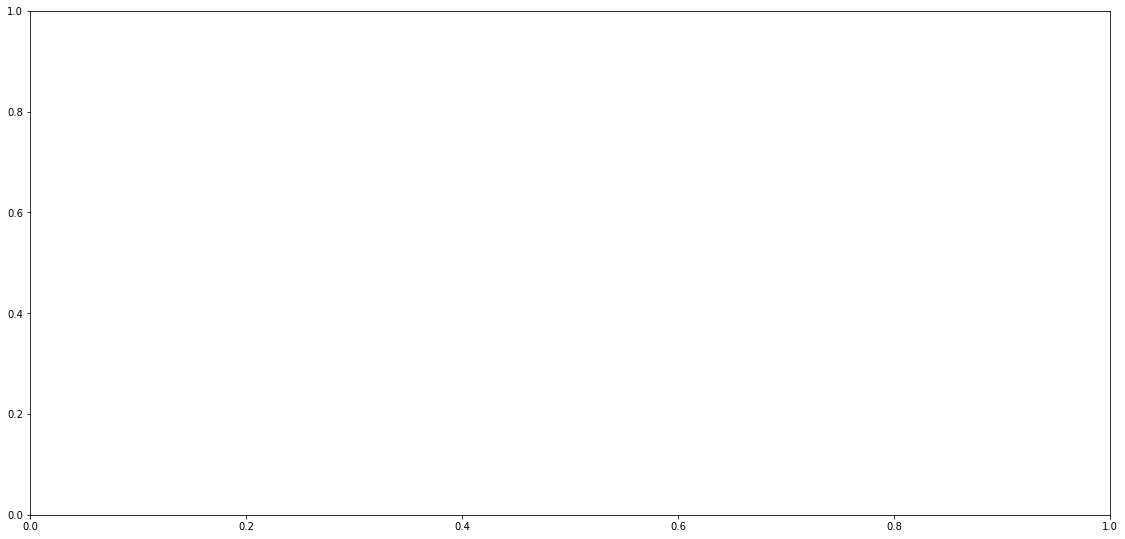

In [15]:
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G)

In [22]:
type(adjM)

scipy.sparse.csr.csr_matrix

In [24]:
M = adjM.todense()

In [26]:
G = nx.from_scipy_sparse_array(adjM)

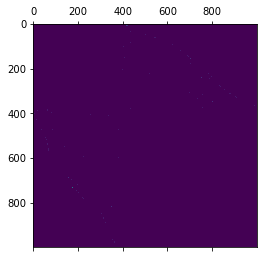

In [27]:
plt.matshow(M)

In [3]:
features_list[0]['logits'].shape

torch.Size([384, 1600, 1600, 2])

In [4]:
import torch
import torch.nn as nn
import dgl
from dgl.nn.pytorch import GraphConv
import dgl.function as fn


# (out_channels, kernel_size, stride, padding)
enzyme_conv_archi = [
    # input: 1600x1600x2
    (2, 4, 4, 0),
    # 400x400x2
    (1, 4, 4, 0),
    # 100x100x1
    (1, 4, 4, 0),
    # 25x25x1
]


class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(Conv2dBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [5]:
class GCN(nn.Module):
    def __init__(self,
                 g,
                 m_dim,
                 num_hidden,
                 num_labels,
                 num_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.g = g
        
        # Enzyme feature
        ## Conv2d layers for enzyme logits
        self.conv2d_layers = nn.ModuleList()
        
        in_channels = 2
        for x in enzyme_conv_archi:
            self.conv2d_layers.append(Conv2dBlock(in_channels, x[0], kernel_size=x[1], stride=x[2], padding=x[3],))
            in_channels = x[0]
            
        self.conv2d_layers.append(nn.Flatten(start_dim=1))
        self.conv2d_layers.append(nn.Linear(625, 64))
        self.dropout_conv2d = nn.Dropout(dropout)
        
        ## Linear layers for enzyme single
        self.single_linear = nn.Linear(1600, 64)
        
        # fc layers: to make the features of all the nodes become the same dimension  
        in_dims = [257, 257]
        self.fc_list = nn.ModuleList(
            [nn.Linear(in_dim, num_hidden, bias=True) for in_dim in in_dims])
        for fc in self.fc_list:
            nn.init.xavier_normal_(fc.weight, gain=1.414)
        
        # GC layers 
        self.GClayers = nn.ModuleList() 
        ## input layer
        self.GClayers.append(
            GraphConv(num_hidden, num_hidden, activation=activation))

        ## hidden layers
        for i in range(num_layers - 1):
            self.GClayers.append(
                GraphConv(num_hidden, num_hidden, activation=activation))

        ## output layer
        self.GClayers.append(GraphConv(num_hidden, num_labels))
        self.dropout_GC = nn.Dropout(p=dropout)

    def forward(self, features_list):        
        # 1. Enzyme feature
        ## 1.1 logits tensor (input [384, 1600, 1600, 2])]))
        e_feature_logits = features_list[0]['logits'].permute(0, 3, 1, 2)

        for i, layer in enumerate(self.conv2d_layers):
            e_feature_logits = self.dropout_conv2d(e_feature_logits)
            e_feature_logits = layer(e_feature_logits)
        # After: e_feature_logits: [384, 64]
        print(f'e_feature_logits: {e_feature_logits.shape}')
        
        ## 1.2 single representation vector
        e_feature_single = features_list[0]['single']
        e_feature_single = self.single_linear(e_feature_single)
        # After: e_feature_single: [384, 64]
        print(f'e_feature_single: {e_feature_single.shape}')
        
        ## 1.3 concatenate logits and single
        e_feature = torch.cat((e_feature_logits, e_feature_single), 1)
        e_dim = e_feature.shape[1]
        # After: e_feature: [384, 128]
        print(f'e_feature: {e_feature.shape}')
        
        # 2. Pad the features of all the nodes and make them the same dimension
        m_feature = features_list[1]
        
        e_feature = torch.cat((e_feature, torch.zeros((e_feature.shape[0], m_dim))), 1)  # [384, e_dim+129] i.e. [616, 257]
        print(f'e_feature: {e_feature.shape}')
        
        m_feature = torch.cat((torch.zeros((m_feature.shape[0], e_dim)), m_feature), 1)  # [616, 128+m_dim] i.e. [616, 257]
        print(f'm_feature: {m_feature.shape}')
        
        features_list = [e_feature, m_feature]
        
        h = []
        for fc, feature in zip(self.fc_list, features_list):
            h.append(fc(feature))
        h = torch.cat(h, 0) # [1000, hidden_dim]
        
        print(f'h: {h.shape}')
        
        # 3. GC layers
        for i, layer in enumerate(self.GClayers):
            h = self.dropout_GC(h)
            h = layer(self.g, h)
            
        # After: h: [1000, num_labels]

        return h


In [6]:
net = GCN(g, m_dim, 128, num_labels, 3, F.elu, 0.2)

In [7]:
logits = net(features_list)

e_feature_logits: torch.Size([384, 64])
e_feature_single: torch.Size([384, 64])
e_feature: torch.Size([384, 128])
e_feature: torch.Size([384, 257])
m_feature: torch.Size([616, 257])
h: torch.Size([1000, 128])


In [8]:
logits.shape

torch.Size([1000, 1])

In [11]:
logits[test_idx].view(-1)

tensor([ 0.1207,  0.0873, -2.1068, -0.5438,  0.3353, -0.0705,  0.1152, -0.5384,
        -0.7481,  0.2721,  0.2563,  0.1787, -0.2580,  0.6081,  0.1568,  0.0520,
         1.1935, -0.1790], grad_fn=<ViewBackward0>)

In [69]:
h = net(features_list)
print(h.shape)

e_feature_logits: torch.Size([384, 64])
e_feature_single: torch.Size([384, 64])
e_feature: torch.Size([384, 128])
e_feature: torch.Size([384, 257])
m_feature: torch.Size([616, 257])
h: torch.Size([1000, 128])
torch.Size([1000, 1])


In [18]:
e_s = features_list[0]['single']
print(e_s.shape)

e_s = nn.Linear(1600, 64)(e_s)

print(e_s.shape)


torch.Size([384, 1600])
torch.Size([384, 64])


In [34]:
e_feature = torch.cat((e, e_s), 1)
e_dim = e_feature.shape[1]
print(e_feature.shape)

torch.Size([384, 128])


In [35]:
m_feature = features_list[1]
print(m_feature.shape)

torch.Size([616, 129])


In [36]:
e_feature = torch.cat((e_feature, torch.zeros((e_feature.shape[0], m_dim))), 1)
print(e_feature.shape)

torch.Size([384, 257])


In [37]:
m_feature = torch.cat((torch.zeros((m_feature.shape[0], e_dim)), m_feature), 1)
print(m_feature.shape)

torch.Size([616, 257])


In [38]:
features_list = [e_feature, m_feature]
h = torch.cat(features_list, 0)
h.shape

torch.Size([1000, 257])

In [10]:
e_feature_logits = features_list[0]['logits']
e_feature_logits.shape

torch.Size([384, 1600, 1600, 2])

In [28]:
# net = Conv2dBlock(2, 2, kernel_size=4, stride=4, padding=0,)

In [29]:
e_feature_logits.permute(0, 3, 1, 2).shape

torch.Size([384, 2, 1600, 1600])

In [30]:
e = net(e_feature_logits.permute(0, 3, 1, 2))

In [31]:
e.shape

torch.Size([384, 2, 400, 400])

In [32]:
torch.flatten(e, start_dim=1).shape

torch.Size([384, 320000])

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load data
features_list, adjM, labels, train_val_test_idx, dl = load_data('iYO844')

In [8]:
fea_list = []

for features in features_list:
    if type(features) == np.ndarray:
        features = mat2tensor(features).to(device)
    elif type(features) == dict:
        features = {k: mat2tensor(v).to(device) for k, v in features.items()}
    fea_list.append(features)
        
fea_list[0]['single']

tensor([[-2.6357, 11.0893,  0.9175,  ...,  0.0000,  0.0000,  0.0000],
        [14.0186, 11.7537, 13.0343,  ...,  0.0000,  0.0000,  0.0000],
        [15.9612, 12.4831,  6.6941,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [17.3412,  9.8042,  8.6208,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.2316,  7.7314,  8.3776,  ...,  0.0000,  0.0000,  0.0000],
        [13.6403, 13.3657, 12.5303,  ...,  0.0000,  0.0000,  0.0000]])

In [4]:
features_list = [mat2tensor(features).to(device)
                    for features in features_list]

AttributeError: 'dict' object has no attribute 'to'

In [3]:
features_list[0]['single']

array([[-2.6357093, 11.089254 ,  0.9175112, ...,  0.       ,  0.       ,
         0.       ],
       [14.018574 , 11.753677 , 13.034294 , ...,  0.       ,  0.       ,
         0.       ],
       [15.961157 , 12.483061 ,  6.694125 , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [17.341208 ,  9.80417  ,  8.620768 , ...,  0.       ,  0.       ,
         0.       ],
       [ 2.231642 ,  7.7314253,  8.377593 , ...,  0.       ,  0.       ,
         0.       ],
       [13.640332 , 13.365712 , 12.530339 , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load data
features_list, adjM, labels, train_val_test_idx, dl = load_data('iYO844')
features_list = [mat2tensor(features).to(device)
                    for features in features_list]
m_dim = features_list[1].shape[1]

# Set train, val, test index
labels = torch.FloatTensor(labels).to(device)
train_idx = train_val_test_idx['train_idx']
train_idx = np.sort(train_idx)
val_idx = train_val_test_idx['val_idx']
val_idx = np.sort(val_idx)
test_idx = train_val_test_idx['test_idx']
test_idx = np.sort(test_idx)

# Build graph
g = dgl.from_scipy(adjM+(adjM.T))
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)
g = g.to(device)

# Set model
num_labels = dl.labels_train['num_labels']

TypeError: expected np.ndarray (got Series)

In [ ]:
features_list

In [6]:
net = GCN(g, m_dim, 64, num_labels, 2, F.elu, 0.1)
net

GCN(
  (layers): ModuleList(
    (0): GraphConv(in=64, out=64, normalization=both, activation=<function elu at 0x7fa205772940>)
    (1): GraphConv(in=64, out=64, normalization=both, activation=<function elu at 0x7fa205772940>)
    (2): GraphConv(in=64, out=2, normalization=both, activation=None)
  )
  (e_conv): Sequential(
    (0): Conv2dBlock(
      (conv): Conv2d(1, 1, kernel_size=(4, 4), stride=(4, 4), bias=False)
      (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): Conv2dBlock(
      (conv): Conv2d(1, 1, kernel_size=(4, 4), stride=(4, 4), bias=False)
      (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (2): Conv2dBlock(
      (conv): Conv2d(1, 1, kernel_size=(4, 4), stride=(4, 4), bias=False)
      (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_run

In [7]:
result = net(features_list)

In [8]:
result.shape

torch.Size([1000, 2])

In [9]:
result

tensor([[ 0.5051, -0.6336],
        [ 0.9062, -1.1658],
        [ 0.9253, -1.0670],
        ...,
        [-0.1441, -0.8804],
        [-0.4972,  1.1266],
        [-0.1885, -1.4643]], grad_fn=<AddBackward0>)